ВНИМАНИЕ!
Данное домашнее задание состоит из двух частей. Для получение 1 балла (зачета) по данному ДЗ достаточно выполнить только Часть 1. Часть 2 является не обязательной, для получения баллов, ее можно выполнить по жаланию!



# Часть 1. Знакомство с Gradio и HuggingFace. Выходим за границу 77 токенов


**ФИО:** Дьячкова Екатерина Николаевна

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*vyzan-cdMVkpcRaVLkhQXA.png)
source: [https://medium.com/@alextakele16/image-generation-using-stable-diffusion-mo-b3cf65481692](https://medium.com/@alextakele16/image-generation-using-stable-diffusion-mo-b3cf65481692)

Мы знаем, что Stable Diffusion 1.x иcпользует CLIP для обработки текстового промпта. При обучении / по умолчанию CLIP работает с текстами до [77 токенов](https://github.com/openai/CLIP/blob/main/clip/clip.py#L205C44-L205C55), что на практике соответствует 30—35 словам на английском языке. Иногда этого может не хватать, в частности при попытке указать много деталей, как в приведенном ниже примере.

In [1]:
from diffusers import StableDiffusionPipeline
import torch
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
def show_images(images):
    return F.to_pil_image(
        make_grid(
            [F.to_tensor(image) for image in images],
            nrow=2
        )
    )

In [3]:
model_id = "SG161222/Realistic_Vision_V3.0_VAE"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
prompt = (
    "Futuristic sports car with sleek aerodynamic design, sharp contours, metallic surfaces reflecting golden and orange hues, "
    "low-profile body with glossy black and silver finish. Hood graffiti, skull on hood, metallic gold skull "
    "Angular LED headlights with neon-blue glow, large air intakes with honeycomb mesh, intricate multi-spoke alloy wheels, glowing brake calipers."
    "Black and white paint, black base, white details, "
    "blue neon text on the hood, stylized, glowing"
)

negative_prompt = "blurry details, low resolution, poorly defined edges"

Token indices sequence length is longer than the specified maximum sequence length for this model (95 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', black base, white details, blue neon text on the hood, stylized, glowing']


  0%|          | 0/20 [00:00<?, ?it/s]

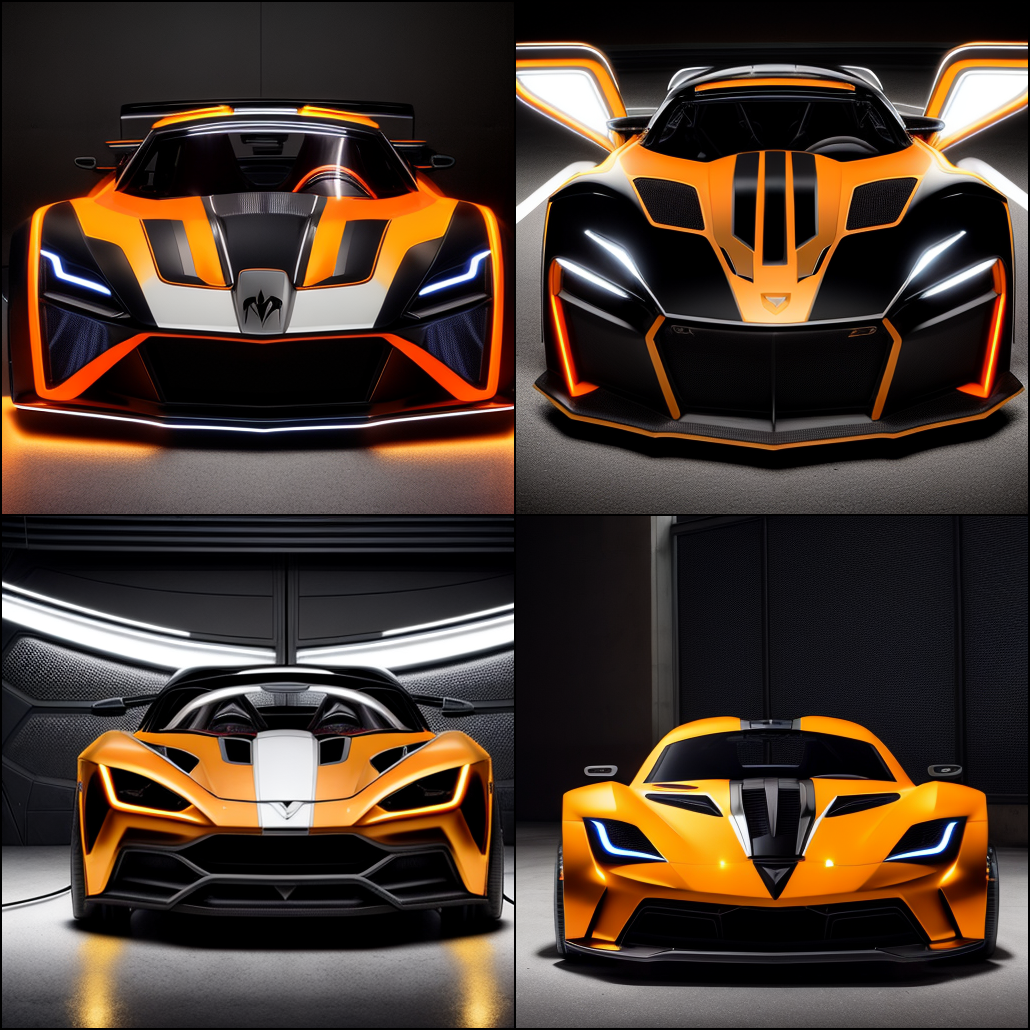

In [5]:
generator = torch.Generator(device="cuda").manual_seed(42)

images_short = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    guidance_scale=6,
    generator=generator,
    num_images_per_prompt=4
).images

show_images(images_short)

### Задание 1

Вместо того чтобы выкидывать все токены, выходящие за лимит CLIP, можно разбить промпт на куски длиной до 77 токенов, обработать их независимо и подать на вход диффузионной модели готовые векторы.

Ваша задача — реализовать это и сгенерировать картинку по всему описанию.


In [6]:
from transformers import CLIPTextModel, CLIPTokenizer


text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16).to("cuda")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

def encode_prompt(prompt, device, tokenizer, text_encoder):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        if len(text_inputs.input_ids[0]) < tokenizer.model_max_length:
            prompt_embeds = text_encoder(text_inputs.input_ids.to(device))[0]
        else:
            embeds = []
            start = 0
            while start < tokenizer.model_max_length:
                end = start + tokenizer.model_max_length
                part_of_text_inputs = text_inputs.input_ids[0][start:end]
                if len(part_of_text_inputs) < tokenizer.model_max_length:
                    part_of_text_inputs = torch.cat([part_of_text_inputs, torch.tensor([tokenizer.pad_token_id] * (tokenizer.model_max_length - len(part_of_text_inputs)))])
                embeds.append(text_encoder(part_of_text_inputs.to(device).unsqueeze(0))[0])
                start += int((7/11)*tokenizer.model_max_length)
            prompt_embeds = torch.mean(torch.stack(embeds, dim=0), dim=0)
    return prompt_embeds

  0%|          | 0/20 [00:00<?, ?it/s]

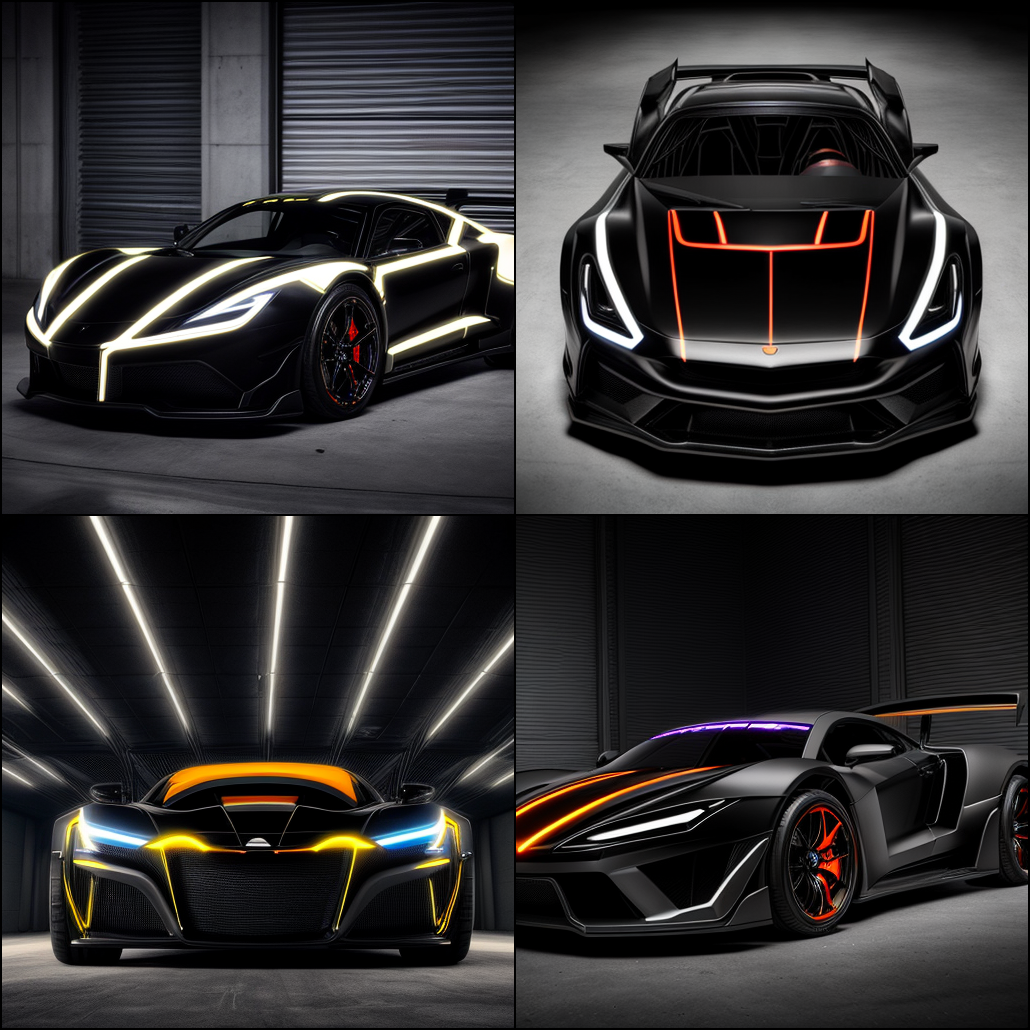

In [7]:
prompt_embeds = encode_prompt(prompt, "cuda", tokenizer, text_encoder)
negative_prompt_embeds = encode_prompt(negative_prompt, "cuda", tokenizer, text_encoder)

images_long = pipe(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    num_inference_steps=20,
    guidance_scale=6,
    generator=generator,
    num_images_per_prompt=4
).images

show_images(images_long)

ВНИМАНИЕ! Часть 2 выполняется по желанию (не является обязательной для получение зачетного балла за данное ДЗ)

# Часть 2. Смотрим внутрь диффузионной модели (работа Cross-Attention)

Во второй части мы посмотрим, как Stable Diffusion 1.x научилась понимать, где и что нужно рисовать. Для этого вспомним, что промпт добавляется в модель через механизм Cross-Attention, то есть потенциально каждый токен может влиять на каждый пиксель латентного пространства.

### Задание 2

Визуализируйте, на что смотрит модель при генерации каждого из токенов. Для этого нарисуйте вероятности из Cross-Attention, отвечающие за один и тот же токен, усредненные по шагам генерации изображения.

### Подсказка 1

Полезная документация: [UNet2DConditionModel.set_attn_processor](https://huggingface.co/docs/diffusers/v0.14.0/en/api/models#diffusers.UNet2DConditionModel.set_attn_processor)

### Подсказка 2

В Stable Diffusion 1.x есть не только Cross-Attention (где картинка смотрит на текст), но и Self-Attention (где картинка смотрит на себя же). Стандартный блок `UNet2DConditionalModel` состоит из одного Self-Attention и одного Cross-Attention, как в приведенном ниже примере.


In [ ]:
pipe.unet.down_blocks[0].attentions[0]

Transformer2DModel(
  (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
  (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
  (transformer_blocks): ModuleList(
    (0): BasicTransformerBlock(
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (attn1): Attention(
        (to_q): Linear(in_features=320, out_features=320, bias=False)
        (to_k): Linear(in_features=320, out_features=320, bias=False)
        (to_v): Linear(in_features=320, out_features=320, bias=False)
        (to_out): ModuleList(
          (0): Linear(in_features=320, out_features=320, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (attn2): Attention(
        (to_q): Linear(in_features=320, out_features=320, bias=False)
        (to_k): Linear(in_features=768, out_features=320, bias=False)
        (to_v): Linear(in_features=768, out_features=320, bias=False)
        (to_out): Modul

In [ ]:
prompt = "A photo of an astronaut riding a horse"

# Your code here.